In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import random

In [21]:
train_dataset = pd.read_csv('signatures/train_data.csv', header=None)
train_dir = "signatures/train"

In [22]:
class DataLoader:
    def __init__(self, dataset, batch_size, dir):
        self.dataset = dataset
        self.batch_size = batch_size
        self.dir = dir

    def shuffle(self):
        return self.dataset.sample(frac=1)

    def preprocess_image(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=1)
        img = tf.image.resize(img, (128, 128))
        img = tf.cast(img, tf.uint8)

        img_cv2 = cv2.Canny(img.numpy(), 20, 220)
        img_cv2 = tf.cast(img_cv2, tf.float32) / 255.0

        return img_cv2

    def datagen(self):
        num_samples = len(self.dataset)
        while True:
            self.dataset = self.shuffle()
            for batch in range(0, num_samples, self.batch_size):
                image1_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 0]]
                image2_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 1]]
                label_batch_samples = self.dataset.iloc[batch:batch + self.batch_size, 2]

                Image1, Image2, Label = [], [], []

                for image1, image2, label in zip(image1_batch_samples, image2_batch_samples, label_batch_samples):
                    image1_data = self.preprocess_image(image1)
                    image2_data = self.preprocess_image(image2)

                    Image1.append(image1_data)
                    Image2.append(image2_data)
                    Label.append(label)

                Image1 = np.asarray(Image1)
                Image2 = np.asarray(Image2)
                Label = np.asarray(Label)

                yield {"image1": Image1, "image2": Image2}, Label

In [23]:
# Split data into training, validation, and test sets
train_set, temp_set = train_test_split(train_dataset, test_size=0.2)
val_set, test_set = train_test_split(temp_set, test_size=0.5)

In [24]:


# Prepare data generators
train_gen = DataLoader(train_set, 256, train_dir)
val_gen = DataLoader(val_set, 256, train_dir)
test_gen = DataLoader(test_set, 256, train_dir)

In [25]:
# Create data generator for plotting
generator = train_gen.datagen()

Pair 1:
Label: 0


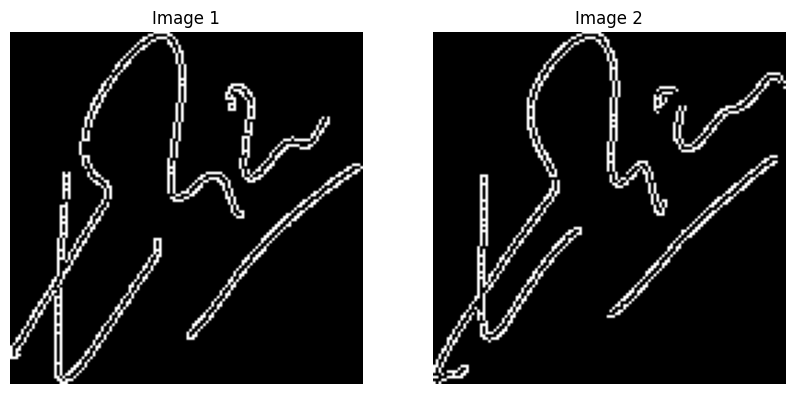

Pair 2:
Label: 1


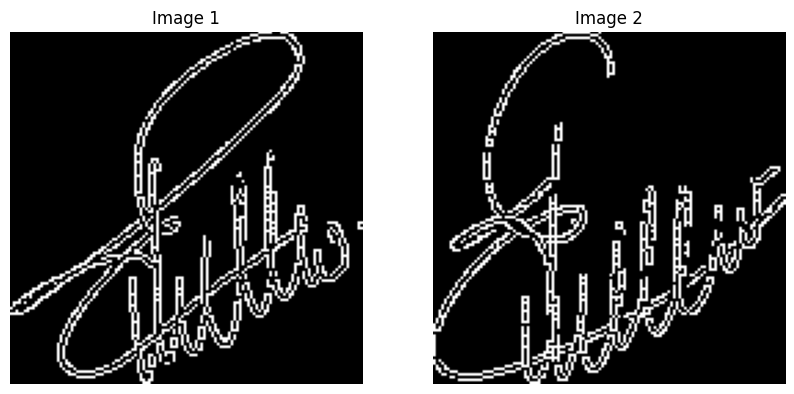

Pair 3:
Label: 0


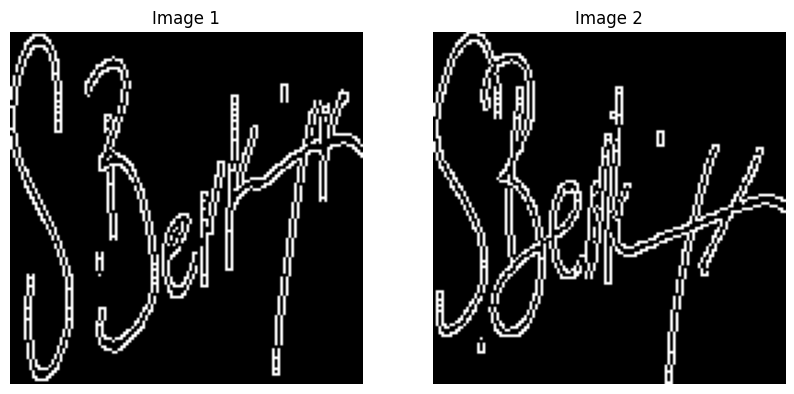

Pair 4:
Label: 1


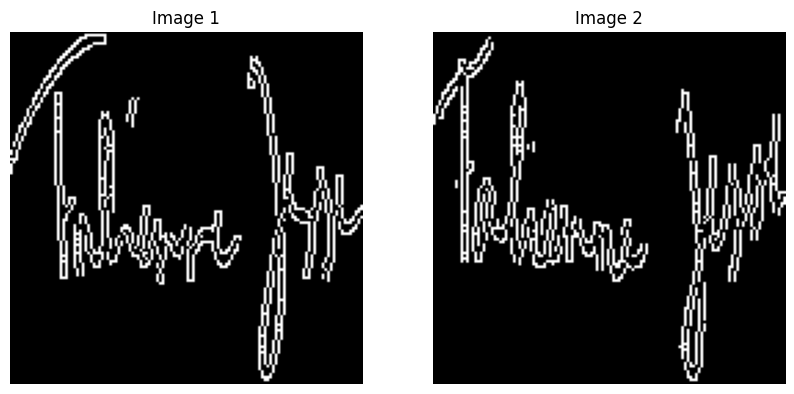

Pair 5:
Label: 0


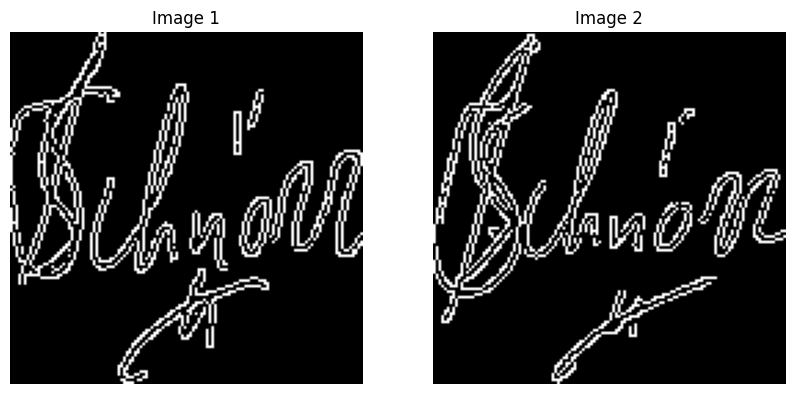

In [26]:
# Plot first 5 images in the batch
for i in range(5):
    batch_data, label = next(generator)
    pair_data = batch_data["image1"], batch_data["image2"]

    print(f"Pair {i + 1}:")
    print("Label:", label[0])

    plt.figure(figsize=(10, 5))
    for j in range(2):
        plt.subplot(1, 2, j + 1)
        plt.imshow(pair_data[j][0], cmap='gray')
        plt.title('Image {}'.format(j + 1))
        plt.axis('off')

    plt.show()

In [23]:
# Siamese Model creation function
def create_siamese_model(input_shape):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(128, activation='relu'),
    ])

    input1 = Input(input_shape, name="image1")
    input2 = Input(input_shape, name="image2")

    embedding1 = model(input1)
    embedding2 = model(input2)

    # Manhattan distance layer
    manhattan_distance_layer = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]), output_shape=(128,))
    manhattan_distance = manhattan_distance_layer([embedding1, embedding2])

    output = Dense(1, activation='sigmoid')(manhattan_distance)

    return Model(inputs=[input1, input2], outputs=output)


In [24]:
input_shape = (128, 128, 1)
model = create_siamese_model(input_shape)
model.summary()

c:\Users\Akshay\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image1 (InputLayer) │ (None, 128, 128,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image2 (InputLayer) │ (None, 128, 128,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 128)       │  2,522,624 │ image1[0][0],     │
│ (Sequential)        │                   │            │ image2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128)       │          0 │ sequential_1[0][… │
│                     │                   │            │ sequential_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        129 │ lambda_1[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,522,753 (9.62 MB)

 Trainable params: 2,522,753 (9.62 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

In [30]:
# Define callbacks
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

callbacks_list = [checkpoint, early_stopping]

In [31]:
# Train model
history = model.fit(x=train_gen.datagen(),
                    steps_per_epoch=len(train_set) // 256,
                    epochs=12,
                    validation_data=val_gen.datagen(),
                    validation_steps=len(val_set) // 256,
                    callbacks=callbacks_list)

Epoch 1/12
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6241 - loss: 0.6475
Epoch 1: val_accuracy improved from -inf to 0.67448, saving model to best_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 331s 5s/step - accuracy: 0.6246 - loss: 0.6471 - val_accuracy: 0.6745 - val_loss: 0.5876
Epoch 2/12
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7448 - loss: 0.5158
Epoch 2: val_accuracy improved from 0.67448 to 0.85182, saving model to best_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 359s 5s/step - accuracy: 0.7451 - loss: 0.5153 - val_accuracy: 0.8518 - val_loss: 0.3792
Epoch 3/12
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8520 - loss: 0.3370 
Epoch 3: val_accuracy improved from 0.85182 to 0.91961, saving model to best_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 690s 10s/step - accuracy: 0.8522 - loss: 0.3367 - val_accuracy: 0.9196 - val_loss: 0.2387
Epoch 4/12
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9105 - loss: 0.2176
Epoch 4: val_accuracy improved from 0.91961 to 0.96223

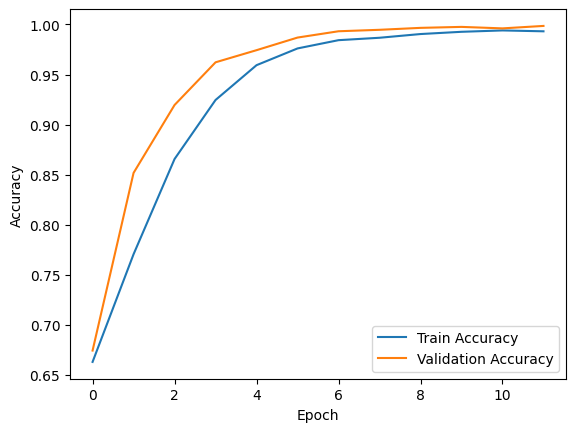

In [32]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
# Load the best model weights
model.load_weights("best_model.keras")

In [35]:
# Evaluate model on test dataset
test_loss, test_accuracy = model.evaluate(test_gen.datagen(), steps=len(test_set) // 256)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9970 - loss: 0.0109
Test Loss: 0.012414827942848206
Test Accuracy: 0.9965277910232544


In [149]:
def preprocess_signature(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=1)  # Assuming your image is a PNG
    img = tf.image.resize(img, (128, 128))
    img = tf.cast(img, tf.uint8)
    
    img_cv2 = cv2.Canny(img.numpy(), 20, 220)
    img_cv2 = tf.cast(img_cv2, tf.float32) / 255.0
    
    return np.expand_dims(img_cv2, axis=0)  # Add batch dimension for prediction

# Example usage:
# signature1 = preprocess_signature("signatures/train/055/01_055.png")
# signature2 = preprocess_signature("signatures/train/055/03_055.png")

signature1 = preprocess_signature("sign2.png")
signature2 = preprocess_signature("test5.png")

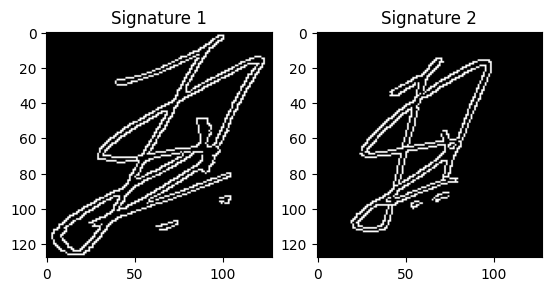

In [146]:
plt.subplot(1, 2, 1)
plt.imshow(signature1.squeeze(), cmap='gray')
plt.title("Signature 1")

plt.subplot(1, 2, 2)
plt.imshow(signature2.squeeze(), cmap='gray')
plt.title("Signature 2")

plt.show()

In [147]:
# Predict similarity
similarity_score = model.predict({"image1": signature1, "image2": signature2})

print(f"Similarity Score: {similarity_score[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Similarity Score: 0.012207970954477787


In [148]:
threshold = 0.5  # Adjust based on your model's training performance

if similarity_score[0][0] < threshold:
    print("The signatures are similar.")
else:
    print("The signatures are not similar.")

The signatures are similar.
